# Exercise 10

Use t-SNE to reduce the first 5000 images of the MNIST dataset down to 2 dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance's class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS, and compare the resulting visualizations.

## Step 1. Get the reduced set

In [5]:
from sklearn.datasets import fetch_openml

# Step 1. Load and obtain reduced dataset
mnist = fetch_openml("mnist_784", version=1, as_frame=False, parser="auto")
X = mnist.data
y = mnist.target
X_5000 = X[:5000]
y_5000 = y[:5000]

## Step 2. Find optimal hyperparameters for tSNE

In [10]:
# from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np

def evaluate_tsne(params, X, labels):
    tsne = TSNE(
        n_components=2,
        perplexity=params['perplexity'],
        n_iter_without_progress=params['n_iter'],
        random_state=42
    )
    # Get the transformed coordinates
    X_embedded = tsne.fit_transform(X)

    # Compute silhouette score - higher is better
    # silhouette score is a metric used to evaluate how well data points are clustered. It measures both:
    # 1. How similar a data point is to its own cluster (cohesion)
    # 2. How different it is from other clusters (separation)
    score = silhouette_score(X_embedded, labels)
    return score

# define parameter grid
# we cannot use `GridSearchCV` or `RandomSearchCV`. tSNE doesn't have a straighgtforward quantitative measure
# of "goodness" through cross-validation like classsification or regression models do. The goal of tSNE is to
# preserve local relationships in high-dimensional data when projecting to lower dimensions, but there is no
# single metric that definitely tells "this is the optimal visualization". Instead we will be relying on 
# an automated parameter search wtih hard-coded values for `perplexity` and `n_iter`. For `n_iter` we may want
# to change the default (300) because of the number of our training set size. For `perplexity` the default (30.0)
# might work well, but we may want to experiment here - this signifies the number of nearest neighbours.
param_grid = {
    'perplexity': [10, 30, 50, 100],
    'n_iter': [300, 500, 1000]
}

# Our manual search
best_score = -1
best_params = None

for perplexity in param_grid['perplexity']:
    for n_iter in param_grid['n_iter']:
        params = { 'perplexity': perplexity, 'n_iter': n_iter }
        score = evaluate_tsne(params, X_5000, y_5000)

        if score > best_score:
            best_score = score
            best_params = params

print("Best tSNE parameters: ", best_params)

Best tSNE parameters:  {'perplexity': 30, 'n_iter': 300}


## Step 3. Run tSNE

In [12]:
tsne_result = TSNE(random_state=42).fit_transform(X_5000)

## Step 4. Plot tSNE results using Matplotlib

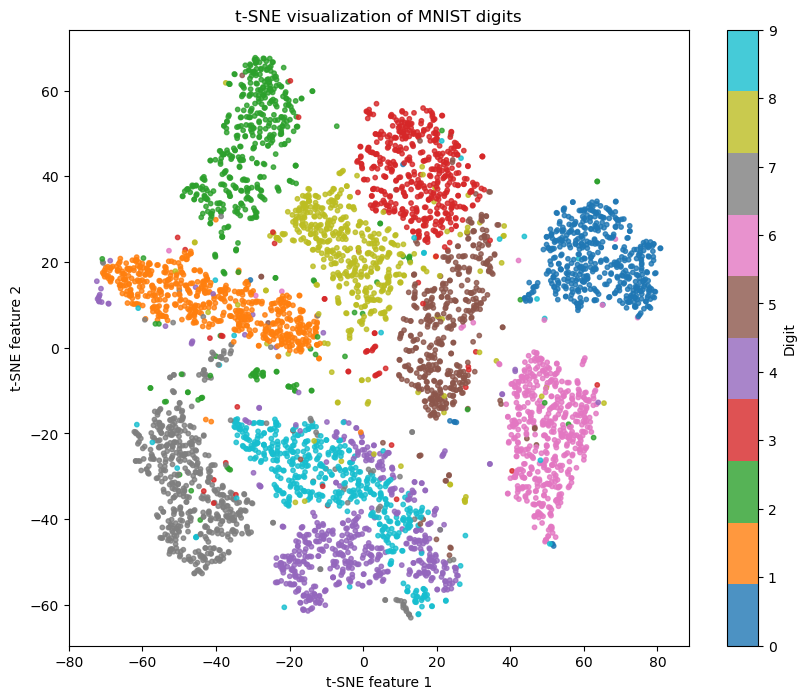

In [29]:
import matplotlib.pyplot as plt

# Convert the string labels to integers
y_5000_int = y_5000.astype(int)

def scatter_plot_reduction_results(results, algorithm_name):
    plt.figure(figsize=(10, 8)) # Create a figure with specified size
    scatter = plt.scatter(
        results[:, 0], # x-coordinates
        results[:, 1], # y-coordinates,
        c = y_5000_int, # color points by digit class,
        cmap = "tab10", # colormap with 10 distinct colors (perfect for digits 0-9)
        alpha=0.8, # slight transparency
        s = 10, # point size
    )
    plt.colorbar(label='Digit')
    plt.title(f'{algorithm_name} visualization of MNIST digits')
    plt.xlabel(f'{algorithm_name} feature 1')
    plt.ylabel(f'{algorithm_name} feature 2')
    plt.savefig(f"{name}_mnist_visualization.png") # save the image locally
    plt.show()

scatter_plot_reduction_results(tsne_result, "t-SNE")

## Step 5. Plot other dimensionality redunction algorithms

### Find optimal `n_neighbors` parameter for LLE

In [16]:
from sklearn.manifold import LocallyLinearEmbedding

def evaluate_lle(n_neighbors, X, labels):
    lle = LocallyLinearEmbedding(
        n_components=2,
        n_neighbors=n_neighbors,
        random_state=42
    )
    # Get the transformed coordinates
    X_embedded = lle.fit_transform(X)

    # Compute silhouette score - higher is better
    # silhouette score is a metric used to evaluate how well data points are clustered. It measures both:
    # 1. How similar a data point is to its own cluster (cohesion)
    # 2. How different it is from other clusters (separation)
    score = silhouette_score(X_embedded, labels)
    return score

best_lle_score = -1
best_lle_n_neighbors = None

for n_neighbors in [5, 10, 20, 30]:
    score = evaluate_lle(n_neighbors, X_5000, y_5000)

    if score > best_lle_score:
        best_lle_score = score
        best_lle_n_neighbors = n_neighbors    

print("Best LLE parameters: ", best_lle_n_neighbors)

Best LLE parameters:  5


In [25]:
import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        return result, execution_time

    return wrapper

In [21]:
@timeit
def run_single_dimensionality_reducer(X_train, dr_algorithm):
    result = dr_algorithm.fit_transform(X_train)
    return result

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

dimensionality_reducing_algorithms = [
    ("PCA", PCA(n_components=2, random_state=42)),
    ("LLE", LocallyLinearEmbedding(n_components=2, random_state=42)),
    ("MDS", MDS(n_components=2, random_state=42, normalized_stress='auto'))
]

PCA took 0.0433 seconds to execute.


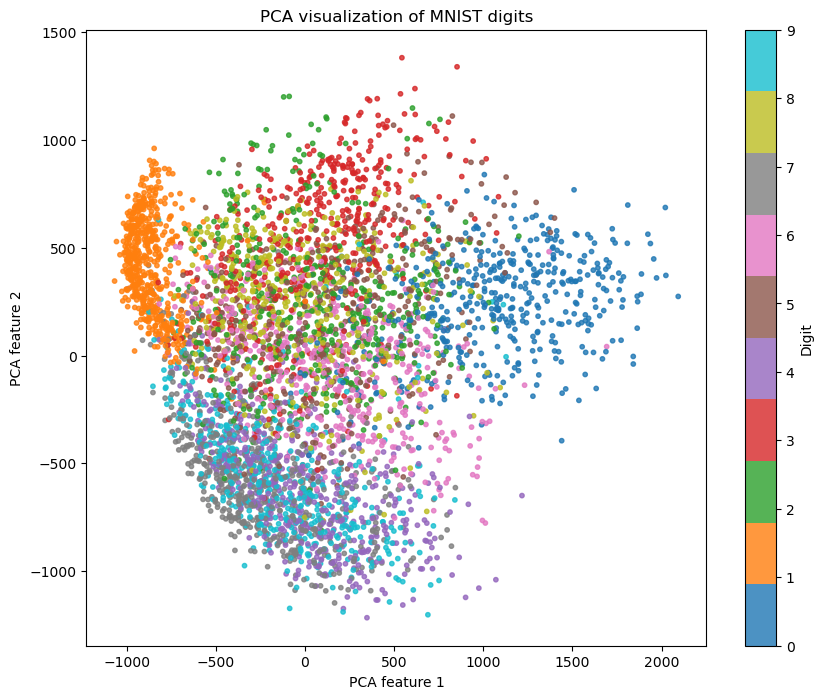

LLE took 1.2790 seconds to execute.


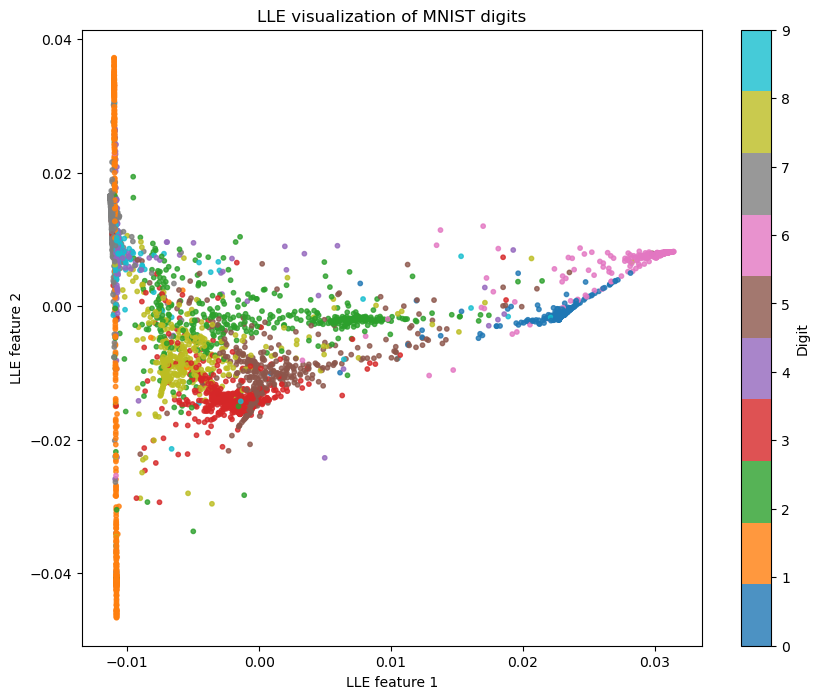

/opt/conda/envs/homl3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS took 384.9734 seconds to execute.


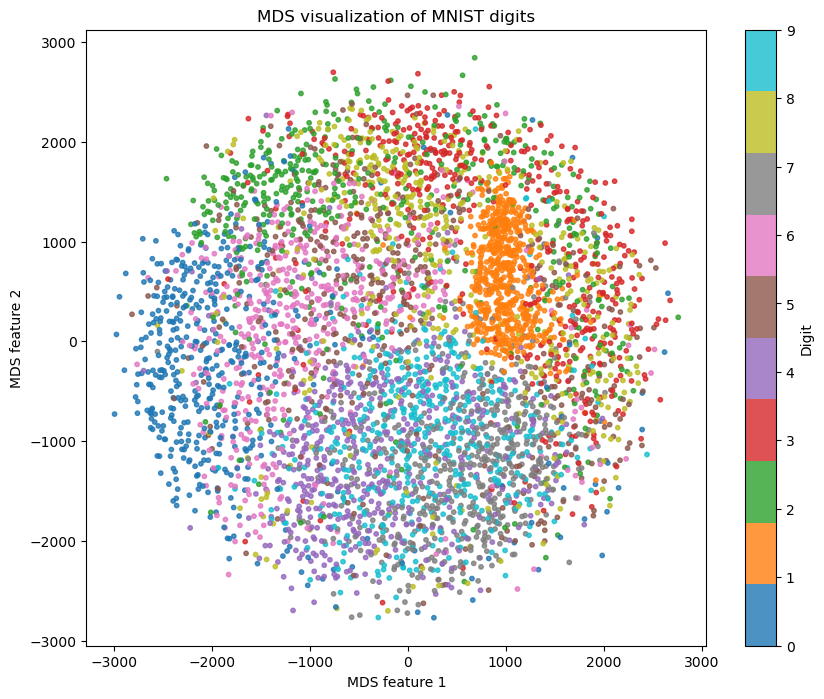

In [27]:
for name, algorithm in dimensionality_reducing_algorithms:
    result, timing = run_single_dimensionality_reducer(X_5000, algorithm)
    print(f"{name} took {timing:.4f} seconds to execute.")
    scatter_plot_reduction_results(result, name)